# 5. Modeling

## 5.1 Imports

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import os

## 5.2 Load previously processed data

In [3]:
# Intermediate data was saved as '../data/baf_cat_dummy_na_median_num_scaled.csv.gz' previously.
baf_data = pd.read_csv('../data/baf_cat_dummy_na_median_num_scaled.csv.gz', compression='gzip')


In [4]:
# Validate data types and non-null values.
baf_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993563 entries, 0 to 993562
Data columns (total 53 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   fraud_bool                        993563 non-null  int64  
 1   email_is_free                     993563 non-null  int64  
 2   phone_home_valid                  993563 non-null  int64  
 3   phone_mobile_valid                993563 non-null  int64  
 4   has_other_cards                   993563 non-null  int64  
 5   foreign_request                   993563 non-null  int64  
 6   keep_alive_session                993563 non-null  int64  
 7   payment_type_AA                   993563 non-null  int64  
 8   payment_type_AB                   993563 non-null  int64  
 9   payment_type_AC                   993563 non-null  int64  
 10  payment_type_AD                   993563 non-null  int64  
 11  payment_type_AE                   993563 non-null  i

## 5.3 Split data into training and testing subsets

All the features will be used for modeling at the first step.

In [5]:
# split dataset into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(baf_data.drop(columns='fraud_bool'), baf_data.fraud_bool, test_size=0.3, random_state=47)

In [6]:
X_train.shape, X_test.shape

((695494, 52), (298069, 52))

In [7]:
y_train.shape, y_test.shape

((695494,), (298069,))

## 5.4 Applying the Machine Learning models

Fraud or not is a classification problem. The following supervised learning classification models will be used:

- Logistic Regression
- K-Nearest Neighbor (KNN)
- Random Forest
- Support vector machine (SVM)
- Naive Bayes
- Gradient Boost

For evaluation metrics, F1 score, Recall, Precision, ROC AUC, PR AUC will be calculated and compared.

In [8]:
# Import
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve


### 5.4.1 Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression

# First we will try LogisticRegresssion model without considering the class_weight

table = pd.DataFrame(columns = ['C_parameter','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['C_parameter'] = [1]

# Apply logistic regression model to training data
logreg = LogisticRegression(penalty='l2', C=1, class_weight=None, random_state=47, max_iter=1000)
logreg.fit(X_train, y_train)

# Predict and save to y_pred
y_pred = logreg.predict(X_test)
y_score = logreg.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[294774     26]
 [  3231     38]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    294800
           1       0.59      0.01      0.02      3269

    accuracy                           0.99    298069
   macro avg       0.79      0.51      0.51    298069
weighted avg       0.98      0.99      0.98    298069

   C_parameter Accuracy_score Precision_score Recall_score  F1_score  \
0            1       0.989073         0.59375     0.011624  0.022802   

  roc_auc_score    pr_auc  
0      0.871519  0.130022  


F1 score 0.022 is very poor. Would it be related to inbalanced classes?

In [10]:
# Print target column `fraud_bool` value count
print(baf_data['fraud_bool'].value_counts())
# Print the pencentage of fraud instances of all records
fraud_bool_1 = len(baf_data[baf_data['fraud_bool']==1]) / len(baf_data)
fraud_bool_0 = len(baf_data[baf_data['fraud_bool']==0]) / len(baf_data)
print(f'fraud_bool=1 of all ratio: {fraud_bool_1: .3f}')
print(f'fraud_bool=0 of all ratio: {fraud_bool_0: .3f}')

fraud_bool
0    982568
1     10995
Name: count, dtype: int64
fraud_bool=1 of all ratio:  0.011
fraud_bool=0 of all ratio:  0.989


We can see that the fraud ratio is very low, only 1.1% of all in baf_data. Next we are going to try class_weight='balanced' in the modeling.

In [11]:
# Try the built in class_weight='balanced'

table = pd.DataFrame(columns = ['C_parameter','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['C_parameter'] = [1]

# Apply logistic regression model to training data
logreg = LogisticRegression(penalty='l2', C=1, class_weight='balanced', random_state=47, max_iter=1000)
logreg.fit(X_train, y_train)

# Predict and save to y_pred
y_pred = logreg.predict(X_test)
y_score = logreg.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)


[[237180  57620]
 [   716   2553]]
              precision    recall  f1-score   support

           0       1.00      0.80      0.89    294800
           1       0.04      0.78      0.08      3269

    accuracy                           0.80    298069
   macro avg       0.52      0.79      0.49    298069
weighted avg       0.99      0.80      0.88    298069

   C_parameter Accuracy_score Precision_score Recall_score  F1_score  \
0            1       0.804287        0.042428     0.780973  0.080483   

  roc_auc_score    pr_auc  
0       0.87257  0.125287  


With the built in 'balanced' class_weight, Recall score increased to 0.78, but Precision decreased to 0.04 as false positive number also increased a lot. F1 score improved to 0.08, better still poor. Accuracy score and roc_auc score doesn't seem to be good choices for inbalanced data classification in the current model. F1 score and pr_auc may be more useful metrics.

In [23]:
# Hyperparameter GridSearch for better parameters.
# penalty, C, class_weight, and solver will be tried.

from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'class_weight': [{0:0.001, 1:0.999}, {0:0.005, 1:0.995}, {0:0.01, 1:0.99}, 
                               {0:0.02, 1:0.98}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}], 
              'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
              }

logreg = LogisticRegression(penalty='l2', random_state=47, max_iter=100000)

cv = GridSearchCV(logreg, param_grid, scoring='f1', cv=5, n_jobs=-1)
cv.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=100000, random_state=47),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'class_weight': [{0: 0.001, 1: 0.999},
                                          {0: 0.005, 1: 0.995},
                                          {0: 0.01, 1: 0.99},
                                          {0: 0.02, 1: 0.98}, {0: 0.1, 1: 0.9},
                                          {0: 0.2, 1: 0.8}],
                         'solver': ['lbfgs', 'newton-cg', 'newton-cholesky',
                                    'sag', 'saga']},
             scoring='f1')

In [24]:
print(f'Best score: {cv.best_score_}')
print(f'Best parameters: {cv.best_params_}')

Best score: 0.21037044297173818
Best parameters: {'C': 0.1, 'class_weight': {0: 0.1, 1: 0.9}, 'solver': 'lbfgs'}


In [26]:
cv.best_estimator_

LogisticRegression(C=0.1, class_weight={0: 0.1, 1: 0.9}, max_iter=100000,
                   random_state=47)

We will use the best parameters found by GridSearchCV to apply logistic regression model for result.

In [18]:
# Use best parameters: {'C': 0.1, 'class_weight': {0: 0.1, 1: 0.9}, 'solver': 'lbfgs'}

table = pd.DataFrame(columns = ['C_parameter','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['C_parameter'] = [0.1]

# Apply logistic regression model to training data
logreg = LogisticRegression(penalty='l2', C=0.1, class_weight={0: 0.1, 1: 0.9}, solver='lbfgs', random_state=47, max_iter=1000)
logreg.fit(X_train, y_train)

# Predict and save to y_pred
y_pred = logreg.predict(X_test)
y_score = logreg.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[290355   4445]
 [  2403    866]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    294800
           1       0.16      0.26      0.20      3269

    accuracy                           0.98    298069
   macro avg       0.58      0.62      0.60    298069
weighted avg       0.98      0.98      0.98    298069

   C_parameter Accuracy_score Precision_score Recall_score  F1_score  \
0          0.1       0.977025        0.163058     0.264913  0.201865   

  roc_auc_score    pr_auc  
0       0.87209  0.128814  


While F1 score is 0.201, Recall and Precision are both low. Let's visulize the result the ROC curve and Precision Recall curve.

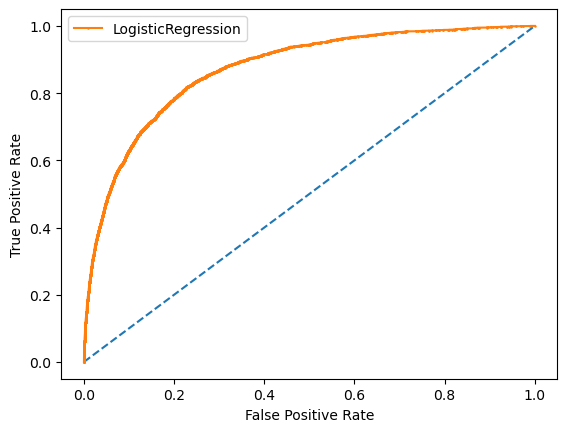

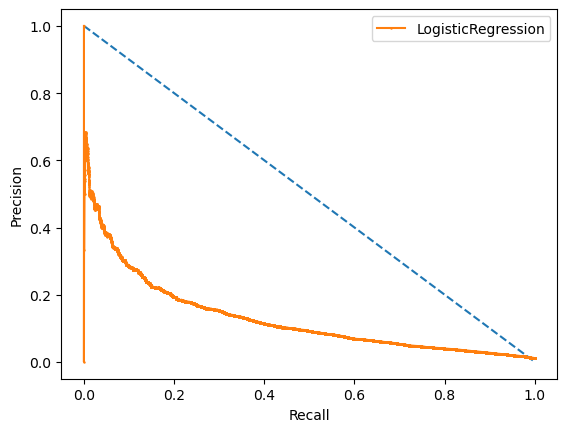

In [12]:
import matplotlib.pyplot as plt

fpr, tpr, thd = roc_curve(y_test, y_score)

# ROC curve
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.', markersize=1.5, label='LogisticRegression')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.show()

# Precision recall curve
plt.plot([0, 1], [1, 0], linestyle='--')
plt.plot(recall, precision, marker='.', markersize=1.5, label='LogisticRegression')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()
plt.show()

From the above two charts, we can see that ROC curve doesn't show the impact of class inbalance. Precision recall curve may be better to use.

### 5.4.2 K-Nearest neighbor (KNN)

In [9]:
from sklearn.neighbors import KNeighborsClassifier

table = pd.DataFrame(columns = ['n_neighbors','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['n_neighbors'] = [50]

# Apply KNN model to the training data
# knn = KNeighborsClassifier(n_neighbors=50, weights='distance', p=2, metric='minkowski', n_jobs=-1)
knn = KNeighborsClassifier(n_neighbors=50, weights='distance', p=2)
knn.fit(X_train, y_train)

# Predict and save to y_pred
y_pred = knn.predict(X_test)
y_score = knn.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

It seems KNN modeling doesn't work well on the current data set. Is it possible for Recall and Precision bother to be 0? Need to discuss with Mentor and try different upsampling or different parameters with KNN and try again.

### 5.4.3 Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

table = pd.DataFrame(columns = ['criterion','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['criterion'] = ['entropy']

# Apply RandomForestClassifier to training data
rfc = RandomForestClassifier(criterion='entropy', random_state=47, n_jobs=-1, class_weight='balanced')
# max-splits: 8 or less than 10, 2 or 3

rfc.fit(X_train, y_train)

# Predict and save to y_pred
y_pred = rfc.predict(X_test)
y_score = rfc.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)


[[294797      3]
 [  3263      6]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    294800
           1       0.67      0.00      0.00      3269

    accuracy                           0.99    298069
   macro avg       0.83      0.50      0.50    298069
weighted avg       0.99      0.99      0.98    298069

  criterion Accuracy_score Precision_score Recall_score  F1_score  \
0   entropy       0.989043        0.666667     0.001835  0.003661   

  roc_auc_score    pr_auc  
0      0.832728  0.127872  


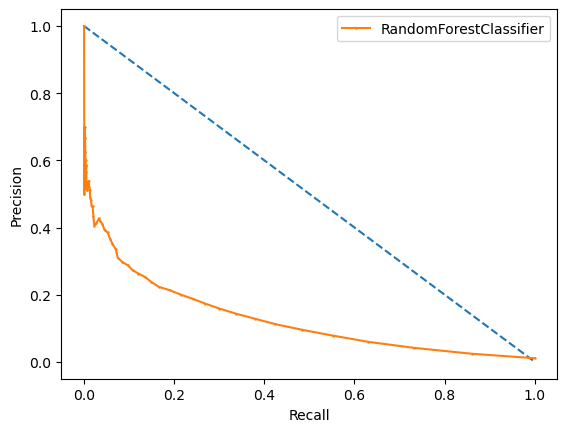

In [ ]:
# Precision recall curve
plt.plot([0, 1], [1, 0], linestyle='--')
plt.plot(recall, precision, marker='.', markersize=1.5, label='RandomForestClassifier')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores_train= cross_val_score(rfc, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
# cv_scores_test= cross_val_score(rfc, X_test, y_test, scoring='f1', cv=5, n_jobs=-1)
print(f'cross validation train scores: {cv_scores_train}')
# print(f'cross validation test scores: {cv_scores_test}')
cv_scores_rf_train= cv_scores_train.mean()
# cv_scores_rf_test= cv_scores_test.mean()
cv_scores_rf_train_std= cv_scores_train.std()
# cv_scores_std_rf= cv_scores_test.std()
print (f'Mean cross validation train score: {cv_scores_rf_train}')
print (f'Standard deviation of cv train scores: {cv_scores_rf_train_std}')
# print (f'Mean cross validation test score: {cv_scores_rf_test}')


cross validation train scores: [0.00258398 0.00129366 0.00773694 0.00129116 0.00514801]
Mean cross validation train score: 0.0036107490056754336
Standard deviation of cv train scores: 0.0024976912126122267


When using F1 score as the metrics, the cross validation scores on train data varied with relatively big deviation.

### 5.4.3-2 Random Forest model with some constraints

In [12]:
from sklearn.ensemble import RandomForestClassifier

table = pd.DataFrame(columns = ['criterion','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['criterion'] = ['entropy']

# Apply RandomForestClassifier to training data
rfc = RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_split=2, max_features=4, random_state=47, n_jobs=-1, class_weight='balanced')
# max-splits: 8 or less than 10, 2 or 3

rfc.fit(X_train, y_train)

# Predict and save to y_pred
y_pred = rfc.predict(X_test)
y_score = rfc.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)


[[247194  47606]
 [   842   2427]]
              precision    recall  f1-score   support

           0       1.00      0.84      0.91    294800
           1       0.05      0.74      0.09      3269

    accuracy                           0.84    298069
   macro avg       0.52      0.79      0.50    298069
weighted avg       0.99      0.84      0.90    298069

  criterion Accuracy_score Precision_score Recall_score  F1_score  \
0   entropy        0.83746        0.048508     0.742429  0.091066   

  roc_auc_score  pr_auc  
0      0.874927  0.1286  


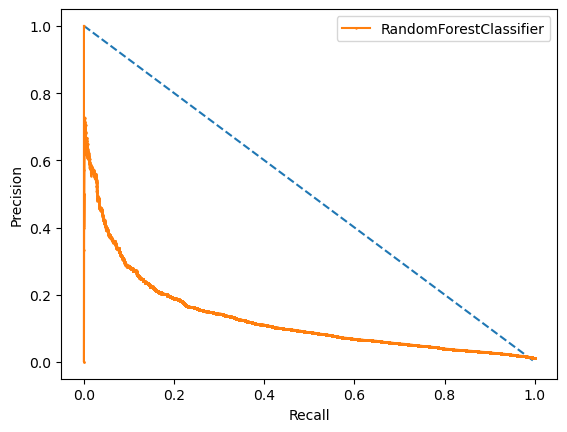

In [13]:
import matplotlib.pyplot as plt

# Precision recall curve
plt.plot([0, 1], [1, 0], linestyle='--')
plt.plot(recall, precision, marker='.', markersize=1.5, label='RandomForestClassifier')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()
plt.show()

### 5.4.4 Gradient Boost

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

table = pd.DataFrame(columns = ['model','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['model'] = ['GradientBoosting']

gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=150, subsample=0.8, max_depth=10, random_state=47)
gbc.fit(X_train, y_train)

# Predict and save to y_pred
y_pred = gbc.predict(X_test)
y_score = gbc.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)


[[293355   1445]
 [  3068    201]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    294800
           1       0.12      0.06      0.08      3269

    accuracy                           0.98    298069
   macro avg       0.56      0.53      0.54    298069
weighted avg       0.98      0.98      0.98    298069

              model Accuracy_score Precision_score Recall_score F1_score  \
0  GradientBoosting       0.984859        0.122114     0.061487  0.08179   

  roc_auc_score    pr_auc  
0      0.877752  0.089802  


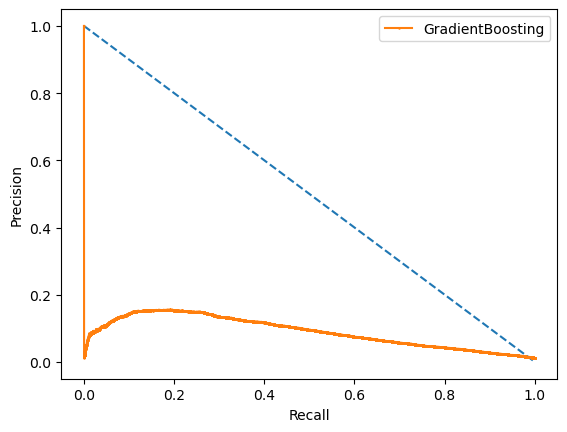

In [24]:
# Precision recall curve
plt.plot([0, 1], [1, 0], linestyle='--')
plt.plot(recall, precision, marker='.', markersize=1.5, label='GradientBoosting')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()
plt.show()

In [23]:

cv_scores_train= cross_val_score(gbc, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
# cv_scores_test= cross_val_score(gbc, X_test, y_test, scoring='f1', cv=5, n_jobs=-1)
print(f'cross validation train scores: {cv_scores_train}')
# print(f'cross validation test scores: {cv_scores_test}')
cv_scores_rf_train= cv_scores_train.mean()
# cv_scores_rf_test= cv_scores_test.mean()
cv_scores_rf_train_std= cv_scores_train.std()
# cv_scores_std_rf= cv_scores_test.std()
print (f'Mean cross validation train score: {cv_scores_rf_train}')
print (f'Standard deviation of cv train scores: {cv_scores_rf_train_std}')
# print (f'Mean cross validation test score: {cv_scores_rf_test}')

cross validation train scores: [0.0793177  0.07705479 0.07017544 0.07839795 0.08490963]
Mean cross validation train score: 0.07797110221487549
Standard deviation of cv train scores: 0.0047275918429300545


## 5.5 Modeling with resampled training data

### 5.5.1 Random over-sampling of fraud data in training data set

In [12]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

print(sorted(Counter(y_train_resampled).items()))

[(0, 687768), (1, 687768)]


### 5.5.2 Random Forest model with some constraints and resampled data

In [13]:
from sklearn.ensemble import RandomForestClassifier

table = pd.DataFrame(columns = ['criterion','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['criterion'] = ['entropy']

# Apply RandomForestClassifier to training data
rfc = RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_split=2, max_features=4, random_state=47, n_jobs=-1)

rfc.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = rfc.predict(X_test)
y_score = rfc.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)


[[244414  50386]
 [   795   2474]]
              precision    recall  f1-score   support

           0       1.00      0.83      0.91    294800
           1       0.05      0.76      0.09      3269

    accuracy                           0.83    298069
   macro avg       0.52      0.79      0.50    298069
weighted avg       0.99      0.83      0.90    298069

  criterion Accuracy_score Precision_score Recall_score  F1_score  \
0   entropy       0.828291        0.046803     0.756806  0.088154   

  roc_auc_score    pr_auc  
0      0.875507  0.129525  


### 5.5.3 Combination of over and under resampling


In [14]:
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# print(sorted(Counter(y_train_resampled).items()))


In [15]:
print(sorted(Counter(y_train_resampled).items()))

[(0, 608306), (1, 687768)]


In [16]:
# from sklearn.ensemble import RandomForestClassifier

table = pd.DataFrame(columns = ['criterion','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['criterion'] = ['entropy']

# Apply RandomForestClassifier to training data
rfc = RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_split=2, max_features=4, random_state=47, n_jobs=-1)

rfc.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = rfc.predict(X_test)
y_score = rfc.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)


[[258729  36071]
 [  1084   2185]]
              precision    recall  f1-score   support

           0       1.00      0.88      0.93    294800
           1       0.06      0.67      0.11      3269

    accuracy                           0.88    298069
   macro avg       0.53      0.77      0.52    298069
weighted avg       0.99      0.88      0.92    298069

  criterion Accuracy_score Precision_score Recall_score  F1_score  \
0   entropy       0.875348        0.057115       0.6684  0.105238   

  roc_auc_score    pr_auc  
0      0.869108  0.113453  


### 5.5.4 Under resampling of not fraud type training data

In [17]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

print(sorted(Counter(y_train_resampled).items()))

[(0, 7726), (1, 7726)]


In [18]:
# from sklearn.ensemble import RandomForestClassifier

table = pd.DataFrame(columns = ['criterion','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['criterion'] = ['entropy']

# Apply RandomForestClassifier to training data
rfc = RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_split=2, max_features=4, random_state=47, n_jobs=-1)

rfc.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = rfc.predict(X_test)
y_score = rfc.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)


[[239652  55148]
 [   747   2522]]
              precision    recall  f1-score   support

           0       1.00      0.81      0.90    294800
           1       0.04      0.77      0.08      3269

    accuracy                           0.81    298069
   macro avg       0.52      0.79      0.49    298069
weighted avg       0.99      0.81      0.89    298069

  criterion Accuracy_score Precision_score Recall_score  F1_score  \
0   entropy       0.812476        0.043732      0.77149  0.082771   

  roc_auc_score    pr_auc  
0      0.873721  0.132063  


### 5.5.5 Under resampling of not fraud type training data, Prototype generation

In [19]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(random_state=42)
X_train_resampled, y_train_resampled = cc.fit_resample(X_train, y_train)

print(sorted(Counter(y_train_resampled).items()))

/home/ematrix/miniconda3/envs/notebook/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[(0, 7726), (1, 7726)]


In [20]:
# from sklearn.ensemble import RandomForestClassifier

table = pd.DataFrame(columns = ['criterion','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['criterion'] = ['entropy']

# Apply RandomForestClassifier to training data
rfc = RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_split=2, max_features=4, random_state=47, n_jobs=-1)

rfc.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = rfc.predict(X_test)
y_score = rfc.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)


[[    20 294780]
 [     0   3269]]
              precision    recall  f1-score   support

           0       1.00      0.00      0.00    294800
           1       0.01      1.00      0.02      3269

    accuracy                           0.01    298069
   macro avg       0.51      0.50      0.01    298069
weighted avg       0.99      0.01      0.00    298069

  criterion Accuracy_score Precision_score Recall_score  F1_score  \
0   entropy       0.011034        0.010968          1.0  0.021698   

  roc_auc_score    pr_auc  
0      0.720985  0.089162  


### 5.5.6 The Synthetic Minority Oversampling Technique (SMOTE)

In [22]:
from collections import Counter
from imblearn.over_sampling import SMOTE

X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_train_resampled).items()))

[(0, 687768), (1, 687768)]


#### 5.5.5.6.1 RandomForest Modeling

In [12]:
from sklearn.ensemble import RandomForestClassifier

table = pd.DataFrame(columns = ['criterion','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['criterion'] = ['entropy']

# Apply RandomForestClassifier to training data
rfc = RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_split=2, max_features=4, random_state=47, n_jobs=-1)

rfc.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = rfc.predict(X_test)
y_score = rfc.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[265789  29011]
 [  1287   1982]]
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    294800
           1       0.06      0.61      0.12      3269

    accuracy                           0.90    298069
   macro avg       0.53      0.75      0.53    298069
weighted avg       0.98      0.90      0.94    298069

  criterion Accuracy_score Precision_score Recall_score  F1_score  \
0   entropy       0.898352         0.06395     0.606302  0.115697   

  roc_auc_score    pr_auc  
0      0.866954  0.112036  


#### 5.5.5.6.2 XGboost Modeling

In [13]:
from xgboost import XGBClassifier

table = pd.DataFrame(columns = ['criterion','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['criterion'] = ['xgb']

# 
xgb = XGBClassifier(objective='binary:logistic', seed=74, eval_metric='aucpr')
xgb.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = xgb.predict(X_test)
y_score = xgb.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[294287    513]
 [  2996    273]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    294800
           1       0.35      0.08      0.13      3269

    accuracy                           0.99    298069
   macro avg       0.67      0.54      0.56    298069
weighted avg       0.98      0.99      0.98    298069

  criterion Accuracy_score Precision_score Recall_score  F1_score  \
0       xgb       0.988228        0.347328     0.083512  0.134649   

  roc_auc_score    pr_auc  
0      0.878641  0.141921  


#### 5.5.5.6.3 KNN

In [14]:
from sklearn.neighbors import KNeighborsClassifier

table = pd.DataFrame(columns = ['n_neighbors','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['n_neighbors'] = [50]

# Apply KNN model to the training data
# knn = KNeighborsClassifier(n_neighbors=50, weights='distance', p=2, metric='minkowski', n_jobs=-1)
knn = KNeighborsClassifier(n_neighbors=50, weights='distance', p=2)
knn.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = knn.predict(X_test)
y_score = knn.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[222956  71844]
 [   945   2324]]
              precision    recall  f1-score   support

           0       1.00      0.76      0.86    294800
           1       0.03      0.71      0.06      3269

    accuracy                           0.76    298069
   macro avg       0.51      0.73      0.46    298069
weighted avg       0.99      0.76      0.85    298069

   n_neighbors Accuracy_score Precision_score Recall_score  F1_score  \
0           50       0.755798        0.031334     0.710921  0.060023   

  roc_auc_score    pr_auc  
0      0.801767  0.084731  


#### 5.5.5.6.4 Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

table = pd.DataFrame(columns = ['C_parameter','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['C_parameter'] = [0.1]

# Apply logistic regression model to training data
logreg = LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', random_state=47, max_iter=1000)
logreg.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = logreg.predict(X_test)
y_score = logreg.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[281414  13386]
 [  1897   1372]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97    294800
           1       0.09      0.42      0.15      3269

    accuracy                           0.95    298069
   macro avg       0.54      0.69      0.56    298069
weighted avg       0.98      0.95      0.96    298069

   C_parameter Accuracy_score Precision_score Recall_score  F1_score  \
0          0.1       0.948727        0.092967       0.4197  0.152216   

  roc_auc_score    pr_auc  
0      0.845516  0.103601  


#### 5.5.5.7 Under-sampling with RandomUnderSampler

In [19]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

print(sorted(Counter(y_train_resampled).items()))

[(0, 7726), (1, 7726)]


#### 5.5.5.7.1 RandomForest Modeling

In [14]:
from sklearn.ensemble import RandomForestClassifier

table = pd.DataFrame(columns = ['criterion','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['criterion'] = ['entropy']

# Apply RandomForestClassifier to training data
rfc = RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_split=2, max_features=4, random_state=47, n_jobs=-1)

rfc.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = rfc.predict(X_test)
y_score = rfc.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[239652  55148]
 [   747   2522]]
              precision    recall  f1-score   support

           0       1.00      0.81      0.90    294800
           1       0.04      0.77      0.08      3269

    accuracy                           0.81    298069
   macro avg       0.52      0.79      0.49    298069
weighted avg       0.99      0.81      0.89    298069

  criterion Accuracy_score Precision_score Recall_score  F1_score  \
0   entropy       0.812476        0.043732      0.77149  0.082771   

  roc_auc_score    pr_auc  
0      0.873721  0.132063  


#### 5.5.5.7.2 XGboost Modeling

In [15]:
from xgboost import XGBClassifier

table = pd.DataFrame(columns = ['criterion','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['criterion'] = ['xgb']

# 
xgb = XGBClassifier(objective='binary:logistic', seed=74, eval_metric='aucpr')
xgb.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = xgb.predict(X_test)
y_score = xgb.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[238011  56789]
 [   676   2593]]
              precision    recall  f1-score   support

           0       1.00      0.81      0.89    294800
           1       0.04      0.79      0.08      3269

    accuracy                           0.81    298069
   macro avg       0.52      0.80      0.49    298069
weighted avg       0.99      0.81      0.88    298069

  criterion Accuracy_score Precision_score Recall_score  F1_score  \
0       xgb       0.807209        0.043666     0.793209  0.082776   

  roc_auc_score    pr_auc  
0      0.881439  0.135744  


#### 5.5.5.7.3 KNN

In [16]:
from sklearn.neighbors import KNeighborsClassifier

table = pd.DataFrame(columns = ['n_neighbors','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['n_neighbors'] = [50]

# Apply KNN model to the training data
# knn = KNeighborsClassifier(n_neighbors=50, weights='distance', p=2, metric='minkowski', n_jobs=-1)
knn = KNeighborsClassifier(n_neighbors=50, weights='distance', p=2)
knn.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = knn.predict(X_test)
y_score = knn.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[217780  77020]
 [   710   2559]]
              precision    recall  f1-score   support

           0       1.00      0.74      0.85    294800
           1       0.03      0.78      0.06      3269

    accuracy                           0.74    298069
   macro avg       0.51      0.76      0.46    298069
weighted avg       0.99      0.74      0.84    298069

   n_neighbors Accuracy_score Precision_score Recall_score  F1_score  \
0           50       0.739221        0.032157     0.782808  0.061776   

  roc_auc_score    pr_auc  
0        0.8365  0.083528  


#### 5.5.5.7.4 Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

table = pd.DataFrame(columns = ['C_parameter','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['C_parameter'] = [0.1]

# Apply logistic regression model to training data
logreg = LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', random_state=47, max_iter=1000)
logreg.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = logreg.predict(X_test)
y_score = logreg.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[237651  57149]
 [   726   2543]]
              precision    recall  f1-score   support

           0       1.00      0.81      0.89    294800
           1       0.04      0.78      0.08      3269

    accuracy                           0.81    298069
   macro avg       0.52      0.79      0.49    298069
weighted avg       0.99      0.81      0.88    298069

   C_parameter Accuracy_score Precision_score Recall_score F1_score  \
0          0.1       0.805834        0.042602     0.777914  0.08078   

  roc_auc_score    pr_auc  
0      0.872246  0.125622  


#### 5.5.5.8 Under-sampling by removing Tomek’s links

In [13]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(n_jobs=-1)
X_train_resampled, y_train_resampled = tl.fit_resample(X_train, y_train)

print(sorted(Counter(y_train_resampled).items()))


[(0, 685578), (1, 7726)]


#### 5.5.5.8.1 RandomForest Modeling

In [14]:
from sklearn.ensemble import RandomForestClassifier

table = pd.DataFrame(columns = ['criterion','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['criterion'] = ['entropy']

# Apply RandomForestClassifier to training data
# Add class_weight='balanced'
rfc = RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_split=2, max_features=4, class_weight='balanced', random_state=47, n_jobs=-1)

rfc.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = rfc.predict(X_test)
y_score = rfc.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[246382  48418]
 [   842   2427]]
              precision    recall  f1-score   support

           0       1.00      0.84      0.91    294800
           1       0.05      0.74      0.09      3269

    accuracy                           0.83    298069
   macro avg       0.52      0.79      0.50    298069
weighted avg       0.99      0.83      0.90    298069

  criterion Accuracy_score Precision_score Recall_score F1_score  \
0   entropy       0.834736        0.047733     0.742429   0.0897   

  roc_auc_score    pr_auc  
0      0.873076  0.127794  


#### 5.5.5.8.2 XGboost Modeling

In [30]:
from xgboost import XGBClassifier

table = pd.DataFrame(columns = ['criterion','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['criterion'] = ['xgb']

# 
xgb = XGBClassifier(objective='binary:logistic', seed=74, eval_metric='aucpr')
xgb.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = xgb.predict(X_test)
y_score = xgb.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[294604    196]
 [  3111    158]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    294800
           1       0.45      0.05      0.09      3269

    accuracy                           0.99    298069
   macro avg       0.72      0.52      0.54    298069
weighted avg       0.98      0.99      0.98    298069

  criterion Accuracy_score Precision_score Recall_score  F1_score  \
0       xgb       0.988905        0.446328     0.048333  0.087221   

  roc_auc_score    pr_auc  
0      0.885752  0.154913  


#### 5.5.5.8.3 KNN

In [31]:
from sklearn.neighbors import KNeighborsClassifier

table = pd.DataFrame(columns = ['n_neighbors','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['n_neighbors'] = [50]

# Apply KNN model to the training data
# knn = KNeighborsClassifier(n_neighbors=50, weights='distance', p=2, metric='minkowski', n_jobs=-1)
knn = KNeighborsClassifier(n_neighbors=50, weights='distance', p=2)
knn.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = knn.predict(X_test)
y_score = knn.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[294800      0]
 [  3268      1]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    294800
           1       1.00      0.00      0.00      3269

    accuracy                           0.99    298069
   macro avg       0.99      0.50      0.50    298069
weighted avg       0.99      0.99      0.98    298069

   n_neighbors Accuracy_score Precision_score Recall_score  F1_score  \
0           50       0.989036             1.0     0.000306  0.000612   

  roc_auc_score    pr_auc  
0      0.771262  0.093185  


#### 5.5.5.8.4 Logistic Regression

In [32]:
table = pd.DataFrame(columns = ['C_parameter','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['C_parameter'] = [0.1]

# Apply logistic regression model to training data
logreg = LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', random_state=47, max_iter=1000)
logreg.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = logreg.predict(X_test)
y_score = logreg.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[294772     28]
 [  3229     40]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    294800
           1       0.59      0.01      0.02      3269

    accuracy                           0.99    298069
   macro avg       0.79      0.51      0.51    298069
weighted avg       0.98      0.99      0.98    298069

   C_parameter Accuracy_score Precision_score Recall_score  F1_score  \
0          0.1       0.989073        0.588235     0.012236  0.023974   

  roc_auc_score    pr_auc  
0      0.871424  0.130207  


#### 5.5.5.9 Under-sampling by EditedNearestNeighbours

In [15]:
from imblearn.under_sampling import EditedNearestNeighbours

enn = EditedNearestNeighbours(n_neighbors=3, n_jobs=-1)
X_train_resampled, y_train_resampled = enn.fit_resample(X_train, y_train)
print(sorted(Counter(y_train_resampled).items()))

[(0, 667924), (1, 7726)]


#### 5.5.5.9.1 RandomForest Modeling

In [16]:
# from sklearn.ensemble import RandomForestClassifier

table = pd.DataFrame(columns = ['criterion','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['criterion'] = ['entropy']

# Apply RandomForestClassifier to training data
# Add class_weight='balanced'
rfc = RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_split=2, max_features=4, class_weight='balanced', random_state=47, n_jobs=-1)

rfc.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = rfc.predict(X_test)
y_score = rfc.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[246942  47858]
 [   840   2429]]
              precision    recall  f1-score   support

           0       1.00      0.84      0.91    294800
           1       0.05      0.74      0.09      3269

    accuracy                           0.84    298069
   macro avg       0.52      0.79      0.50    298069
weighted avg       0.99      0.84      0.90    298069

  criterion Accuracy_score Precision_score Recall_score  F1_score  \
0   entropy       0.836622        0.048303     0.743041  0.090709   

  roc_auc_score    pr_auc  
0      0.873774  0.126791  


#### 5.5.5.9.2 XGboost Modeling

In [35]:
from xgboost import XGBClassifier

table = pd.DataFrame(columns = ['criterion','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['criterion'] = ['xgb']

# 
xgb = XGBClassifier(objective='binary:logistic', seed=74, eval_metric='aucpr')
xgb.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = xgb.predict(X_test)
y_score = xgb.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[294387    413]
 [  2994    275]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    294800
           1       0.40      0.08      0.14      3269

    accuracy                           0.99    298069
   macro avg       0.69      0.54      0.57    298069
weighted avg       0.98      0.99      0.98    298069

  criterion Accuracy_score Precision_score Recall_score  F1_score  \
0       xgb        0.98857        0.399709     0.084124  0.138994   

  roc_auc_score    pr_auc  
0      0.889849  0.160301  


#### 5.5.5.9.3 KNN

In [36]:
table = pd.DataFrame(columns = ['n_neighbors','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['n_neighbors'] = [50]

# Apply KNN model to the training data
# knn = KNeighborsClassifier(n_neighbors=50, weights='distance', p=2, metric='minkowski', n_jobs=-1)
knn = KNeighborsClassifier(n_neighbors=50, weights='distance', p=2)
knn.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = knn.predict(X_test)
y_score = knn.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[294793      7]
 [  3256     13]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    294800
           1       0.65      0.00      0.01      3269

    accuracy                           0.99    298069
   macro avg       0.82      0.50      0.50    298069
weighted avg       0.99      0.99      0.98    298069

   n_neighbors Accuracy_score Precision_score Recall_score  F1_score  \
0           50       0.989053            0.65     0.003977  0.007905   

  roc_auc_score    pr_auc  
0      0.774667  0.096543  


#### 5.5.5.9.4 Logistic Regression

In [37]:
table = pd.DataFrame(columns = ['C_parameter','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['C_parameter'] = [0.1]

# Apply logistic regression model to training data
logreg = LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', random_state=47, max_iter=1000)
logreg.fit(X_train_resampled, y_train_resampled)

# Predict and save to y_pred
y_pred = logreg.predict(X_test)
y_score = logreg.predict_proba(X_test)[:, 1]

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print score values
print(table)

[[294705     95]
 [  3184     85]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    294800
           1       0.47      0.03      0.05      3269

    accuracy                           0.99    298069
   macro avg       0.73      0.51      0.52    298069
weighted avg       0.98      0.99      0.98    298069

   C_parameter Accuracy_score Precision_score Recall_score F1_score  \
0          0.1       0.988999        0.472222     0.026002  0.04929   

  roc_auc_score    pr_auc  
0      0.871013  0.130367  


#### 5.5.5.10 Stacking modeling

In [12]:
from sklearn.ensemble import StackingClassifier
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as Pipeline_imb
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

pipe_xgb = Pipeline_imb([
    ('rus', RandomUnderSampler(random_state=42)), 
    ('model_1', XGBClassifier(objective='binary:logistic', seed=74, eval_metric='aucpr', n_jobs=-1))
])

pipe_knn = Pipeline_imb([
    ('enn', EditedNearestNeighbours(n_neighbors=3, n_jobs=-1)), 
    ('model_2', KNeighborsClassifier(n_neighbors=50, weights='distance', p=2, n_jobs=-1))
])

level0 = list()
level0.append(('xgboost', pipe_xgb))
level0.append(('knn', pipe_knn))

level1 = LogisticRegression(random_state=74, n_jobs=-1)

model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5, n_jobs=-1)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:, 1]

table = pd.DataFrame(columns = ['model','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['model'] = ['stacking']

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[294770     30]
 [  3233     36]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    294800
           1       0.55      0.01      0.02      3269

    accuracy                           0.99    298069
   macro avg       0.77      0.51      0.51    298069
weighted avg       0.98      0.99      0.98    298069



In [13]:
print(table)

      model Accuracy_score Precision_score Recall_score  F1_score  \
0  stacking       0.989053        0.545455     0.011013  0.021589   

  roc_auc_score    pr_auc  
0      0.881819  0.129291  


In [14]:
from sklearn.ensemble import StackingClassifier
from imblearn.pipeline import Pipeline as Pipeline_imb
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from imblearn.under_sampling import TomekLinks
from sklearn.linear_model import LogisticRegression

pipe_xgb = Pipeline_imb([
    ('rus', RandomUnderSampler(random_state=42)), 
    ('model_1', XGBClassifier(objective='binary:logistic', seed=74, eval_metric='aucpr', n_jobs=-1))
])

pipe_lgb = Pipeline_imb([
    ('tl', TomekLinks(n_jobs=-1)), 
    ('model_2', LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', random_state=47, max_iter=1000, n_jobs=-1))
])

level0 = list()
level0.append(('xgboost', pipe_xgb))
level0.append(('lbg', pipe_lgb))

level1 = LogisticRegression(random_state=74, n_jobs=-1)

model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5, n_jobs=-1)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:, 1]

table = pd.DataFrame(columns = ['model','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['model'] = ['stacking']

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print(table)

[[294740     60]
 [  3207     62]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    294800
           1       0.51      0.02      0.04      3269

    accuracy                           0.99    298069
   macro avg       0.75      0.51      0.52    298069
weighted avg       0.98      0.99      0.98    298069

      model Accuracy_score Precision_score Recall_score  F1_score  \
0  stacking       0.989039        0.508197     0.018966  0.036567   

  roc_auc_score    pr_auc  
0      0.884291  0.144066  


In [15]:
from sklearn.ensemble import StackingClassifier
from imblearn.pipeline import Pipeline as Pipeline_imb
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import TomekLinks
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

pipe_rfc = Pipeline_imb([
    ('rus', RandomUnderSampler(random_state=42)), 
    ('model_1', RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_split=2, max_features=4, random_state=47, n_jobs=-1))
])

pipe_xgb = Pipeline_imb([
    ('tl', TomekLinks(n_jobs=-1)), 
    ('model_2', XGBClassifier(objective='binary:logistic', seed=74, eval_metric='aucpr', n_jobs=-1))
])

level0 = list()
level0.append(('rfc', pipe_rfc))
level0.append(('xgb', pipe_xgb))

level1 = LogisticRegression(random_state=74, n_jobs=-1)

model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5, n_jobs=-1)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:, 1]

table = pd.DataFrame(columns = ['model','Accuracy_score', 'Precision_score', 'Recall_score', 'F1_score', 'roc_auc_score', 'pr_auc'])
table['model'] = ['stacking']

# Save score values in table
table.iloc[0, 1] = accuracy_score(y_test, y_pred)
table.iloc[0, 2] = precision_score(y_test, y_pred)
table.iloc[0, 3] = recall_score(y_test, y_pred)
table.iloc[0, 4] = f1_score(y_test, y_pred)
table.iloc[0, 5] = roc_auc_score(y_test, y_score)

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
table.iloc[0, 6] = auc(recall, precision)

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print(table)

[[294699    101]
 [  3144    125]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    294800
           1       0.55      0.04      0.07      3269

    accuracy                           0.99    298069
   macro avg       0.77      0.52      0.53    298069
weighted avg       0.98      0.99      0.98    298069

      model Accuracy_score Precision_score Recall_score  F1_score  \
0  stacking       0.989113        0.553097     0.038238  0.071531   

  roc_auc_score    pr_auc  
0      0.877583  0.153836  


#### 5.5.6 Neural network modeling

#### 5.5.6.1 Oversample the minority class with SMOTE

In [11]:
from collections import Counter
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(sorted(Counter(y_train_resampled).items()))


[(0, 687768), (1, 687768)]


#### 5.5.6.2 Build the Neural Network Model

In [16]:
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import precision_recall_curve, auc
import tensorflow as tf

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model with precision, recall, and AUC metrics
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[Precision(), Recall(), AUC(name='auc')]
)


c:\Users\shenj\miniconda3\envs\datascience\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# Create a Custom Callback for AUC-PR

class AUC_PR(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(AUC_PR, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_predict = np.asarray(self.model.predict(self.validation_data[0]))
        val_targ = self.validation_data[1]
        precision, recall, _ = precision_recall_curve(val_targ, val_predict)
        auc_pr = auc(recall, precision)
        print(f' - val_auc_pr: {auc_pr:.4f}')
        logs['val_auc_pr'] = auc_pr

In [18]:
# Train the Model with the Custom Callback

# Split the training data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.2, random_state=42
)

# Define early stopping and custom AUC-PR callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
auc_pr_callback = AUC_PR(validation_data=(X_val_split, y_val_split))

# Train the model
history = model.fit(
    X_train_split, y_train_split,
    epochs=100,
    batch_size=32,    # limit of memory, also the running speed
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping, auc_pr_callback],
    verbose=1
)

Epoch 1/100
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
 - val_auc_pr: 0.9920
34389/34389 ━━━━━━━━━━━━━━━━━━━━ 92s 3ms/step - auc: 0.9673 - loss: 0.2146 - precision: 0.9184 - recall: 0.9096 - val_auc: 0.9910 - val_loss: 0.1186 - val_precision: 0.9629 - val_recall: 0.9421 - val_auc_pr: 0.9920
Epoch 2/100
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step
 - val_auc_pr: 0.9926
34389/34389 ━━━━━━━━━━━━━━━━━━━━ 99s 3ms/step - auc: 0.9879 - loss: 0.1364 - precision: 0.9570 - recall: 0.9392 - val_auc: 0.9915 - val_loss: 0.1139 - val_precision: 0.9612 - val_recall: 0.9490 - val_auc_pr: 0.9926
Epoch 3/100
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
 - val_auc_pr: 0.9927
34389/34389 ━━━━━━━━━━━━━━━━━━━━ 93s 3ms/step - auc: 0.9886 - loss: 0.1320 - precision: 0.9577 - recall: 0.9420 - val_auc: 0.9917 - val_loss: 0.1127 - val_precision: 0.9625 - val_recall: 0.9487 - val_auc_pr: 0.9927
Epoch 4/100
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
 - val_auc_pr: 0.9929
34389/34389 ━━━━━━━━━━━━━━━━━━━━ 141s 3ms/s

#### 5.5.6.3 Evaluate the Model

In [19]:
# Evaluate on the test data
results = model.evaluate(X_test, y_test)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value}")

# Predict on test data
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# Confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

9315/9315 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - auc: 0.8440 - loss: 0.1173 - precision: 0.1058 - recall: 0.3602
loss: 0.11628413200378418
compile_metrics: 0.1044442430138588
9315/9315 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98    294800
           1       0.10      0.36      0.16      3269

    accuracy                           0.96    298069
   macro avg       0.55      0.66      0.57    298069
weighted avg       0.98      0.96      0.97    298069

[[284785  10015]
 [  2101   1168]]


In [21]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score

print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print(roc_auc_score(y_test, y_score))

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
print(auc(recall, precision))

0.9593516937353431
0.10444424573012609
0.3572958091159376
0.1616385275394409
0.8725704481845618
0.12528700350742578


Drop out test.

In [12]:
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import precision_recall_curve, auc
import tensorflow as tf

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model with precision, recall, and AUC metrics
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[Precision(), Recall(), AUC(name='auc')]
)

# Create a Custom Callback for AUC-PR

class AUC_PR(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(AUC_PR, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_predict = np.asarray(self.model.predict(self.validation_data[0]))
        val_targ = self.validation_data[1]
        precision, recall, _ = precision_recall_curve(val_targ, val_predict)
        auc_pr = auc(recall, precision)
        print(f' - val_auc_pr: {auc_pr:.4f}')
        logs['val_auc_pr'] = auc_pr

# Train the Model with the Custom Callback

# Split the training data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.2, random_state=42
)

# Define early stopping and custom AUC-PR callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
auc_pr_callback = AUC_PR(validation_data=(X_val_split, y_val_split))

# Train the model
history = model.fit(
    X_train_split, y_train_split,
    epochs=100,
    batch_size=32,    # limit of memory, also the running speed
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping, auc_pr_callback],
    verbose=1
)

# Evaluate on the test data
results = model.evaluate(X_test, y_test)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value}")

# Predict on test data
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# Confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))


c:\Users\shenj\miniconda3\envs\datascience\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
 - val_auc_pr: 0.9928
34389/34389 ━━━━━━━━━━━━━━━━━━━━ 92s 3ms/step - auc: 0.9774 - loss: 0.1793 - precision: 0.9339 - recall: 0.9207 - val_auc: 0.9918 - val_loss: 0.1123 - val_precision: 0.9570 - val_recall: 0.9549 - val_auc_pr: 0.9928
Epoch 2/100
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
 - val_auc_pr: 0.9932
34389/34389 ━━━━━━━━━━━━━━━━━━━━ 86s 2ms/step - auc: 0.9903 - loss: 0.1220 - precision: 0.9574 - recall: 0.9487 - val_auc: 0.9924 - val_loss: 0.1089 - val_precision: 0.9552 - val_recall: 0.9609 - val_auc_pr: 0.9932
Epoch 3/100
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
 - val_auc_pr: 0.9935
34389/34389 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - auc: 0.9909 - loss: 0.1181 - precision: 0.9586 - recall: 0.9511 - val_auc: 0.9927 - val_loss: 0.1058 - val_precision: 0.9576 - val_recall: 0.9607 - val_auc_pr: 0.9935
Epoch 4/100
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step
 - val_auc_pr: 0.9938
34389/34389 ━━━━━━━━━━━━━━━━━━━━ 125s 4ms/s

In [13]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98    294800
           1       0.10      0.37      0.16      3269

    accuracy                           0.96    298069
   macro avg       0.55      0.67      0.57    298069
weighted avg       0.98      0.96      0.97    298069

[[284224  10576]
 [  2056   1213]]


Normalization

In [12]:
from collections import Counter
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(sorted(Counter(y_train_resampled).items()))

#---------------------------------------------
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import precision_recall_curve, auc
import tensorflow as tf

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model with precision, recall, and AUC metrics
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[Precision(), Recall(), AUC(name='auc')]
)

# Create a Custom Callback for AUC-PR

class AUC_PR(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(AUC_PR, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_predict = np.asarray(self.model.predict(self.validation_data[0]))
        val_targ = self.validation_data[1]
        precision, recall, _ = precision_recall_curve(val_targ, val_predict)
        auc_pr = auc(recall, precision)
        print(f' - val_auc_pr: {auc_pr:.4f}')
        logs['val_auc_pr'] = auc_pr

# Train the Model with the Custom Callback

# Split the training data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.2, random_state=42
)

# Define early stopping and custom AUC-PR callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
auc_pr_callback = AUC_PR(validation_data=(X_val_split, y_val_split))

# Train the model
history = model.fit(
    X_train_split, y_train_split,
    epochs=100,
    batch_size=32,    # limit of memory, also the running speed
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping, auc_pr_callback],
    verbose=1
)

# Evaluate on the test data
results = model.evaluate(X_test, y_test)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value}")

# Predict on test data
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# Confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

#--------------------------------------
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score

print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print(roc_auc_score(y_test, y_score))

# Compute the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Compute the area under precision-recall curve (pr_auc)
print(auc(recall, precision))


[(0, 687768), (1, 687768)]


c:\Users\shenj\miniconda3\envs\datascience\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
 - val_auc_pr: 0.9926
34389/34389 ━━━━━━━━━━━━━━━━━━━━ 103s 3ms/step - auc: 0.9740 - loss: 0.1939 - precision: 0.9260 - recall: 0.9196 - val_auc: 0.9916 - val_loss: 0.1146 - val_precision: 0.9611 - val_recall: 0.9473 - val_auc_pr: 0.9926
Epoch 2/100
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
 - val_auc_pr: 0.9929
34389/34389 ━━━━━━━━━━━━━━━━━━━━ 100s 3ms/step - auc: 0.9873 - loss: 0.1396 - precision: 0.9506 - recall: 0.9443 - val_auc: 0.9921 - val_loss: 0.1121 - val_precision: 0.9545 - val_recall: 0.9574 - val_auc_pr: 0.9929
Epoch 3/100
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
 - val_auc_pr: 0.9931
34389/34389 ━━━━━━━━━━━━━━━━━━━━ 143s 3ms/step - auc: 0.9890 - loss: 0.1307 - precision: 0.9539 - recall: 0.9467 - val_auc: 0.9923 - val_loss: 0.1102 - val_precision: 0.9649 - val_recall: 0.9458 - val_auc_pr: 0.9931
Epoch 4/100
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
 - val_auc_pr: 0.9933
34389/34389 ━━━━━━━━━━━━━━━━━━━━ 98s 3ms